# Lane Detection and Modeltraining of DDQN Model

- lane detection is based on: https://medium.com/@ldesegur/a-lane-detection-approach-for-self-driving-vehicles-c5ae1679f7ee
    - comments are kept from the original notebook mostly
    - therefore comments are not in the PeP 8 format
    - ChatGPT has been utilized to add additional comments
- modeltraining is inspired by:  https://github.com/flyyufelix/donkey_rl/blob/master/donkey_rl/src/ddqn.py

In [1]:
# import necessary packages 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import random
import signal
import sys
import uuid
from collections import deque

import cv2
import gym
import gym_donkeycar
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from typing import List, Tuple

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size = 5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    lines_image = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(lines_image, lines)
    return lines_image, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.7, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [3]:
def pipeline(original_image: np.ndarray) -> np.ndarray:
    """
    Process an original image to detect lane lines.

    This function applies a series of image processing steps to detect lane lines in
    the input image.

    Args:
        original_image (numpy.ndarray): The input image.

    Returns:
        numpy.ndarray: The output image with detected lane lines.
    """
    # Get the size of the input image
    ysize, xsize = original_image.shape[:2]

    # Define region of interest vertices
    bottom_left = (120, ysize)
    top_left = (440, 318)
    top_right = (552, 318)
    bottom_right = (930, ysize)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    # Step 1: Convert the image to grayscale
    output_image_gray = grayscale(original_image)

    # Step 2: Apply Gaussian blur to the grayscale image
    output_image = gaussian_blur(output_image_gray, 3)

    # Step 3: Apply Canny edge detection to the blurred image
    output_image_canny = canny(output_image, 50, 150)

    # Step 4: Apply a mask to focus on the region of interest
    output_image = region_of_interest(output_image_canny, vertices)

    # Step 5: Detect and draw Hough lines on the region of interest
    lines_image, lines = hough_lines(output_image, 1, np.pi/180, 15, 20, 10)

    # Step 6: Apply a mask to focus on the region of interest for the lines image
    lines_image = region_of_interest(lines_image, vertices)

    # Step 7: Convert the lines image to grayscale
    lines_image = grayscale(lines_image)

    # Step 8: Combine the lines image with the Canny edge-detected image
    final_image = weighted_img(lines_image, output_image_canny)

    # Optional Step 9: Combine the lines image with the detected Hough lines
    # final_image = weighted_img(lines_image, lines)

    return final_image, lines

In [20]:
def get_slope(x1: int, y1: int, x2: int, y2: int) -> float:
    """
    Calculate the slope of a line given two points (x1, y1) and (x2, y2).

    Args:
        x1 (int): x-coordinate of the first point.
        y1 (int): y-coordinate of the first point.
        x2 (int): x-coordinate of the second point.
        y2 (int): y-coordinate of the second point.

    Returns:
        float: The slope of the line passing through the given points.
    """
    return (y1 - y2) / (x1 - x2)

def reject_outliers(data: List[List[float]], cutoff: Tuple[float, float], threshold: float = 0.08) -> np.ndarray:
    """
    Remove outliers from a list of data points based on a cutoff and a threshold.

    Args:
        data (List[List[float]]): List of data points with each row containing [x1, y1, x2, y2, slope].
        cutoff (Tuple[float, float]): The range within which the slope should lie to be considered.
        threshold (float, optional): The allowable deviation from the mean slope. Defaults to 0.08.

    Returns:
        numpy.ndarray: Array of data points without outliers based on the given cutoff and threshold.
    """
    data = np.array(data)
    data = data[(data[:, 4] >= cutoff[0]) & (data[:, 4] <= cutoff[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m + threshold) & (data[:, 4] >= m - threshold)]

def separate_lines(lines: np.ndarray, use_apply_along_axis: bool = True) -> Tuple[List[List[float]], List[List[float]]]:
    """
    Separate lines into right and left based on their slopes.

    Args:
        lines (numpy.ndarray): Array of lines, each row containing [x1, y1, x2, y2].
        use_apply_along_axis (bool, optional): Whether to use apply_along_axis method. Defaults to True.

    Returns:
        Tuple[List[List[float]], List[List[float]]]: Two lists of lines - right and left.
    """
    right = []
    left = []
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            m = get_slope(x1, y1, x2, y2)
            if m >= 0:
                right.append([x1, y1, x2, y2, m])
            else:
                left.append([x1, y1, x2, y2, m])
    return right, left



def extend_point(x1: int, y1: int, x2: int, y2: int, length: int) -> Tuple[int, int]:
    """
    Extend a line segment defined by two points (x1, y1) and (x2, y2) by a given length.

    Args:
        x1 (int): x-coordinate of the first point.
        y1 (int): y-coordinate of the first point.
        x2 (int): x-coordinate of the second point.
        y2 (int): y-coordinate of the second point.
        length (int): The length by which to extend the line segment.

    Returns:
        Tuple[int, int]: The extended point coordinates (x, y).
    """
    line_len = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y

def merge_lines(lines: List[List[float]]) -> np.ndarray:
    """
    Merge a list of lines into a single line segment by averaging their endpoints.

    Args:
        lines (List[List[float]]): List of lines, each row containing [x1, y1, x2, y2, slope].

    Returns:
        numpy.ndarray: The merged line segment, with coordinates (x1, y1, x2, y2) as an array.
    """
    lines = np.array(lines)[:, :4]  # Drop the last column (slope)
    x1, y1, x2, y2 = np.mean(lines, axis=0)
    x1e, y1e = extend_point(x1, y1, x2, y2, -1000)  # bottom point
    x2e, y2e = extend_point(x1, y1, x2, y2, 1000)   # top point
    line = np.int32([[x1e, y1e, x2e, y2e]])
    line = np.array([[x1e, y1e, x2e, y2e]])

    return np.array([line], dtype=np.int32)

def compute_lane(img: np.ndarray, lines: List[List[float]]) -> np.ndarray:
    """
    Compute the lane line from a list of lines by merging and extending them.

    Args:
        img (numpy.ndarray): The input image.
        lines (List[List[float]]): List of lines, each row containing [x1, y1, x2, y2, slope].

    Returns:
        numpy.ndarray: The computed lane line with coordinates (x1, y1, x2, y2) as an array.
    """
    if len(lines) == 0:
        return None
    
    x1, y1, x2, y2 = merge_lines(lines)

    x1e, y1e = extend_point(x1, y1, x2, y2, -1000)  # bottom point
    x2e, y2e = extend_point(x1, y1, x2, y2, 1000)   # top point

    lane = np.array([x2e, y2e, x1e, y1e], dtype=np.int32)
    return lane

def extrapolate_lines(img: np.ndarray, lines: List[List[float]]) -> np.ndarray:
    """
    Extrapolate lines from a list of lines, separating them based on their slopes.

    Args:
        img (numpy.ndarray): The input image.
        lines (List[List[float]]): List of lines, each row containing [x1, y1, x2, y2, slope].

    Returns:
        numpy.ndarray: Array of extrapolated lines, each row containing [x1, y1, x2, y2].
    """
    right_lines, left_lines = separate_lines(lines)

    if len(right_lines) == 0 or len(left_lines) == 0:
        return 

    right = reject_outliers(right_lines, cutoff=(0.45, 0.75))
    right = merge_lines(right)

    left = reject_outliers(left_lines, cutoff=(-1.1, -0.2))
    left = merge_lines(left)
    
    lines = np.concatenate((right, left))
    return lines

def extrapolate_lines(img, lines):
    right_lines, left_lines = separate_lines(lines)

    if len(right_lines) == 0 or len(left_lines) == 0:
        return 

    right = reject_outliers(right_lines, cutoff=(0.45, 0.75))
    right = merge_lines(right)

    left = reject_outliers(left_lines, cutoff=(-1.1, -0.2))
    left = merge_lines(left)
    
    lines = np.concatenate((right, left))
    return lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    lines = extrapolate_lines(img, lines)
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness=5)
    return img


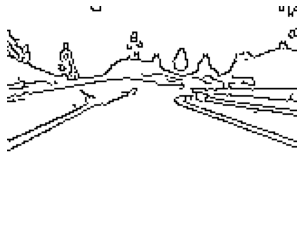

In [24]:
# test line separator for one image of the donkeycar environment

image = cv2.imread(r"..\data\dataset-mountain\89.jpg")
image_new, lines = pipeline(image)
plt.imshow(image_new, cmap="Greys")
plt.axis("off")
plt.savefig(r"..\data\sample_line_detected_image.jpg")

(-0.5, 159.5, 119.5, -0.5)

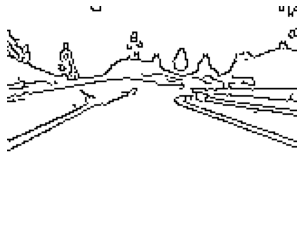

In [25]:
# draw main lines

img_lines = draw_lines(image_new, lines)
plt.imshow(img_lines, cmap="Greys")
plt.axis("off")

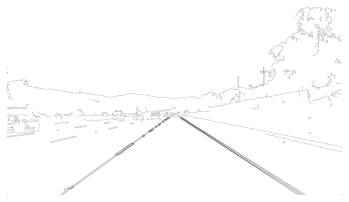

In [22]:
# test line separator for one image of the real-world

image = cv2.imread(r"..\data\test_lane_seperator.png")
image_new, lines = pipeline(image)
plt.imshow(image_new, cmap="Greys")
plt.axis("off")
plt.savefig(r"..\data\sample_line_detected_image.jpg")

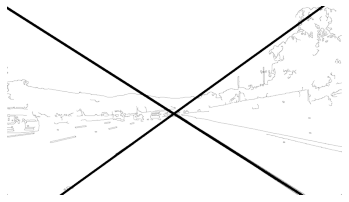

In [23]:
# draw main lines

img_lines = draw_lines(image_new, lines)
plt.imshow(img_lines, cmap="Greys")
plt.axis("off")
plt.savefig(r"..\data\sample_line_detected_image.jpg")

In [62]:
# SET UP ENVIRONMENT
# You can also launch the simulator separately
# in that case, you don't need to pass a `conf` object
PATH_TO_APP = r"C:\Users\Phili\Desktop\RL_Project\DonkeySimWin"
exe_path = f"{PATH_TO_APP}/donkey_sim.exe"

In [70]:
"""
file: ddqn.py
author: Felix Yu
date: 2018-09-12
original: https://github.com/flyyufelix/donkey_rl/blob/master/donkey_rl/src/ddqn.py
"""

EPISODES = 2000
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames


class DQNAgent:
    def __init__(self, state_size, action_space, train=True):
        self.t = 0
        self.max_Q = 0
        self.train = train

        # Get size of state and action
        self.state_size = state_size
        self.action_space = action_space
        self.action_size = action_space

        # These are hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 1e-4
        if self.train:
            self.epsilon = 1.0
            self.initial_epsilon = 1.0
        else:
            self.epsilon = 1e-6
            self.initial_epsilon = 1e-6
        self.epsilon_min = 0.02
        self.batch_size = 16
        self.train_start = 100
        self.explore = EPISODES

        # Create replay memory using deque
        self.memory = deque(maxlen=10000)

        # Create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # Copy the model to target model
        # --> initialize the target model so that the parameters of model & target model to be same
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(
            Conv2D(24, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows, img_cols, img_channels))
        )  # 80*80*4
        model.add(Activation("relu"))
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
        model.add(Activation("relu"))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))

        # 15 categorical bins for Steering angles
        model.add(Dense(15, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)

        return model

    # # def build_model

    # def rgb2gray(self, rgb):
    #     """
    #     take a numpy rgb image return a new single channel image converted to greyscale
    #     """
    #     return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

    def process_image(self, obs):
        obs = pipeline(obs)
        # obs = self.rgb2gray(obs)
        obs = cv2.resize(obs, (img_rows, img_cols))
        return obs

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # Get action from model using epsilon-greedy policy
    def get_action(self, s_t):
        if np.random.rand() <= self.epsilon:
            return self.action_space.sample()[0]
        else:
            # print("Return Max Q Prediction")
            q_value = self.model.predict(s_t)

            # Convert q array to steering value
            return linear_unbin(q_value[0])

    def replay_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= (self.initial_epsilon - self.epsilon_min) / self.explore

    def train_replay(self):
        if len(self.memory) < self.train_start:
            return

        batch_size = min(self.batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)

        state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
        state_t = np.concatenate(state_t)
        state_t1 = np.concatenate(state_t1)
        targets = self.model.predict(state_t)
        self.max_Q = np.max(targets[0])
        target_val = self.model.predict(state_t1)
        target_val_ = self.target_model.predict(state_t1)
        for i in range(batch_size):
            if terminal[i]:
                targets[i][action_t[i]] = reward_t[i]
            else:
                a = np.argmax(target_val[i])
                targets[i][action_t[i]] = reward_t[i] + self.discount_factor * (target_val_[i][a])

        self.model.train_on_batch(state_t, targets)

    def load_model(self, name):
        self.model.load_weights(name)

    # Save the model which is under training
    def save_model(self, name):
        self.model.save_weights(name)


# Utils Functions #


def linear_bin(a):
    """
    Convert a value to a categorical array.

    Parameters
    ----------
    a : int or float
        A value between -1 and 1

    Returns
    -------
    list of int
        A list of length 15 with one item set to 1, which represents the linear value, and all other items set to 0.
    """
    a = a + 1
    b = round(a / (2 / 14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return arr


def linear_unbin(arr):
    """
    Convert a categorical array to value.

    See Also
    --------
    linear_bin
    """
    if not len(arr) == 15:
        raise ValueError("Illegal array length, must be 15")
    b = np.argmax(arr)
    a = b * (2 / 14) - 1
    return a


def run_ddqn(description: str, model: str, test: bool, throttle: float, env_name: str,
             port: int, sim: str):
    """
    run a DDQN training session, or test it's result, with the donkey simulator
    """

    # only needed if TF==1.13.1
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True
    # sess = tf.Session(config=config)
    # K.set_session(sess)

    conf = {
        "exe_path": sim,
        "host": "127.0.0.1",
        "port": port,
        "body_style": "donkey",
        "body_rgb": (128, 128, 128),
        "car_name": "me",
        "font_size": 100,
        "racer_name": "DDQN",
        "country": "USA",
        "bio": "Learning to drive w DDQN RL",
        "guid": str(uuid.uuid4()),
        "max_cte": 10,
    }

    # Construct gym environment. Starts the simulator if path is given.
    env = gym.make(env_name, conf=conf)

    # not working on windows...
    def signal_handler(signal, frame):
        print("catching ctrl+c")
        env.unwrapped.close()
        sys.exit(0)

    signal.signal(signal.SIGINT, signal_handler)
    signal.signal(signal.SIGTERM, signal_handler)
    signal.signal(signal.SIGABRT, signal_handler)

    # Get size of state and action from environment
    state_size = (img_rows, img_cols, img_channels)
    action_space = env.action_space  # Steering and Throttle

    try:
        agent = DQNAgent(state_size, action_space, train=not test)

        throttle = throttle  # Set throttle as constant value

        episodes = []

        if os.path.exists(model):
            print("load the saved model")
            agent.load_model(model)

        for e in range(EPISODES):

            print("Episode: ", e)

            done = False
            obs = env.reset()

            episode_len = 0

            x_t = agent.process_image(obs)

            s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
            # In Keras, need to reshape
            s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  # 1*80*80*4

            while not done:

                # Get action for the current state and go one step in environment
                steering = agent.get_action(s_t)
                action = [steering, throttle]
                next_obs, reward, done, info = env.step(action)

                x_t1 = agent.process_image(next_obs)

                x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1)  # 1x80x80x1
                s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)  # 1x80x80x4

                # Save the sample <s, a, r, s'> to the replay memory
                agent.replay_memory(s_t, np.argmax(linear_bin(steering)), reward, s_t1, done)
                agent.update_epsilon()

                if agent.train:
                    agent.train_replay()

                s_t = s_t1
                agent.t = agent.t + 1
                episode_len = episode_len + 1
                if agent.t % 30 == 0:
                    print(
                        "EPISODE",
                        e,
                        "TIMESTEP",
                        agent.t,
                        "/ ACTION",
                        action,
                        "/ REWARD",
                        reward,
                        "/ EPISODE LENGTH",
                        episode_len,
                        "/ Q_MAX ",
                        agent.max_Q,
                    )

                if done:

                    # Every episode update the target model to be same with model
                    agent.update_target_model()

                    episodes.append(e)

                    # Save model for each episode
                    if agent.train:
                        agent.save_model(model)

                    print(
                        "episode:",
                        e,
                        "  memory length:",
                        len(agent.memory),
                        "  epsilon:",
                        agent.epsilon,
                        " episode length:",
                        episode_len,
                    )

    except KeyboardInterrupt:
        print("stopping run...")
    finally:
        env.unwrapped.close()

    return episodes, agent.replay_memory


if __name__ == "__main__":

    # Initialize the donkey environment
    # where env_name one of:
    env_list = [
        "donkey-warehouse-v0",
        "donkey-generated-roads-v0",
        "donkey-avc-sparkfun-v0",
        "donkey-generated-track-v0",
        "donkey-roboracingleague-track-v0",
        "donkey-waveshare-v0",
        "donkey-minimonaco-track-v0",
        "donkey-warren-track-v0",
        "donkey-thunderhill-track-v0",
        "donkey-circuit-launch-track-v0",
    ]

    description = "ddqn"
    model = "rl_model_200_epochs.h5"
    test = False
    throttle = 0.3
    env_name = "donkey-minimonaco-track-v0"
    port = 9091
    sim = exe_path

    episodes, replay = run_ddqn(description = description, model = model, test = test, throttle = throttle, env_name = env_name,
                                port = port, sim = sim)

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started


INFO:gym_donkeycar.core.client:connecting to 127.0.0.1:9091 


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


load the saved model
Episode:  0
EPISODE 0 TIMESTEP 30 / ACTION [-0.50125444, 0.3] / REWARD 0.6513898579132874 / EPISODE LENGTH 30 / Q_MAX  0
EPISODE 0 TIMESTEP 60 / ACTION [0.22192402, 0.3] / REWARD 1.034838805825884 / EPISODE LENGTH 60 / Q_MAX  0
episode: 0   memory length: 86   epsilon: 0.9578600000000008  episode length: 86
Episode:  1
EPISODE 1 TIMESTEP 90 / ACTION [-0.4061286, 0.3] / REWARD 0.037527462760760695 / EPISODE LENGTH 4 / Q_MAX  0
1/1 [==============================] - 0s 157ms/step
episode: 1   memory length: 101   epsilon: 0.950510000000001  episode length: 15
Episode:  2
1/1 [==============================] - 0s 207ms/step
episode: 2   memory length: 103   epsilon: 0.949530000000001  episode length: 2
Episode:  3
1/1 [==============================] - 0s 393ms/step
episode: 3   memory length: 106   epsilon: 0.948060000000001  episode length: 3
Episode:  4
1/1 [==============================] - 0s 304ms/step
episode: 4   memory length: 110   epsilon: 0.946100000000001

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.09 seconds


1/1 [==============================] - 0s 235ms/step
episode: 586   memory length: 1835   epsilon: 0.10085000000001684  episode length: 3
Episode:  587
1/1 [==============================] - 0s 265ms/step
episode: 587   memory length: 1838   epsilon: 0.09938000000001683  episode length: 3
Episode:  588
1/1 [==============================] - 0s 210ms/step
episode: 588   memory length: 1841   epsilon: 0.09791000000001682  episode length: 3
Episode:  589
1/1 [==============================] - 0s 213ms/step
episode: 589   memory length: 1844   epsilon: 0.0964400000000168  episode length: 3
Episode:  590
1/1 [==============================] - 0s 228ms/step
episode: 590   memory length: 1847   epsilon: 0.09497000000001679  episode length: 3
Episode:  591
1/1 [==============================] - 0s 203ms/step
episode: 591   memory length: 1851   epsilon: 0.09301000000001677  episode length: 4
Episode:  592
1/1 [==============================] - 0s 201ms/step
episode: 592   memory length: 1854  

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.02 seconds


1/1 [==============================] - 0s 404ms/step
episode: 1388   memory length: 3879   epsilon: 0.019510000000016653  episode length: 2
Episode:  1389
1/1 [==============================] - 0s 394ms/step
episode: 1389   memory length: 3882   epsilon: 0.019510000000016653  episode length: 3
Episode:  1390
1/1 [==============================] - 0s 386ms/step
episode: 1390   memory length: 3884   epsilon: 0.019510000000016653  episode length: 2
Episode:  1391
1/1 [==============================] - 0s 415ms/step
episode: 1391   memory length: 3886   epsilon: 0.019510000000016653  episode length: 2
Episode:  1392
1/1 [==============================] - 0s 391ms/step
episode: 1392   memory length: 3889   epsilon: 0.019510000000016653  episode length: 3
Episode:  1393
1/1 [==============================] - 0s 433ms/step
episode: 1393   memory length: 3891   epsilon: 0.019510000000016653  episode length: 2
Episode:  1394
1/1 [==============================] - 0s 389ms/step
episode: 1394   m

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.12 seconds


1/1 [==============================] - 0s 440ms/step
EPISODE 1550 TIMESTEP 4230 / ACTION [0.4285714285714284, 0.3] / REWARD -1.0 / EPISODE LENGTH 2 / Q_MAX  493188.88
episode: 1550   memory length: 4230   epsilon: 0.019510000000016653  episode length: 2
Episode:  1551
1/1 [==============================] - 0s 415ms/step
episode: 1551   memory length: 4232   epsilon: 0.019510000000016653  episode length: 2
Episode:  1552
1/1 [==============================] - 0s 397ms/step
episode: 1552   memory length: 4234   epsilon: 0.019510000000016653  episode length: 2
Episode:  1553
1/1 [==============================] - 0s 431ms/step
episode: 1553   memory length: 4236   epsilon: 0.019510000000016653  episode length: 2
Episode:  1554
1/1 [==============================] - 0s 411ms/step
episode: 1554   memory length: 4238   epsilon: 0.019510000000016653  episode length: 2
Episode:  1555
1/1 [==============================] - 0s 408ms/step
episode: 1555   memory length: 4240   epsilon: 0.019510000

INFO:gym_donkeycar.envs.donkey_sim:New lap time: 2.02 seconds


1/1 [==============================] - 0s 471ms/step
episode: 1948   memory length: 5088   epsilon: 0.019510000000016653  episode length: 2
Episode:  1949
1/1 [==============================] - 0s 466ms/step
episode: 1949   memory length: 5090   epsilon: 0.019510000000016653  episode length: 2
Episode:  1950
1/1 [==============================] - 0s 455ms/step
episode: 1950   memory length: 5092   epsilon: 0.019510000000016653  episode length: 2
Episode:  1951
1/1 [==============================] - 0s 407ms/step
episode: 1951   memory length: 5094   epsilon: 0.019510000000016653  episode length: 2
Episode:  1952
1/1 [==============================] - 0s 491ms/step
episode: 1952   memory length: 5096   epsilon: 0.019510000000016653  episode length: 2
Episode:  1953
1/1 [==============================] - 0s 414ms/step
episode: 1953   memory length: 5099   epsilon: 0.019510000000016653  episode length: 3
Episode:  1954
1/1 [==============================] - 0s 472ms/step
EPISODE 1954 TIME